# Read dataset and create data loaders

In [12]:
# Import torch and CIFAR dataset
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F

# Import matplotlib and numpy for graphs
import matplotlib.pyplot as plt
import numpy as np


In [13]:
'''
Import CIFAR dataset, define labbels and load training and validation dataset
Reference for loading dataset: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
Reference for augmentation: https://pytorch.org/vision/stable/transforms.html
'''
batch_size=64 
print('Batch size:', batch_size)

# Normalisation and std values for RGB in dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation for training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding
    transforms.RandomHorizontalFlip(),    # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomRotation(15),        # Randomly rotate the image by up to 15 degrees
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Randomly translate the image
    transforms.ToTensor(),                # Convert image to tensor
    transforms.Normalize(mean=mean, std=std),  # Normalize with mean and std
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.3))  # Randomly erase a portion of the image (optional)
])

# No augmentation for test set (only normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Normalize with mean and std
])

# Load training and testing datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'lorry')

Batch size: 64
Files already downloaded and verified
Files already downloaded and verified


In [14]:
# # From the PyTorch's tutorial on image classification
# import matplotlib.pyplot as plt
# import numpy as np

# def imshow(img):
#     '''
#     Show an image
#     Input: image file to show
#     Output: image
#     '''
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # Get random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # Show images
# imshow(torchvision.utils.make_grid(images))
# # Print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Main model
Divided as such:


*   **Stem**: takes the images as inputs, extracts features from them
*   **Backbone**: made up of *K* branches, made up of an expert branch
*   **Classifier**: takes input from the last block
*   **Model**: wraps all together







## Stem
*   Takes images as inputs
*   Extracts a feature representation from them

In [15]:
class Stem(nn.Module):
  '''
  Extract features using a Resnet-18 stem
  Reference: Week 09 Lab
  '''
  def __init__(self, input_channels, middle_channels, output_channels):
     super(Stem,self).__init__()
     # Default parameters
     kernel_size=3
     stride=1
     padding=1
     
     # Combine multiple layers
     self.stem = nn.Sequential(
       nn.Conv2d(input_channels, middle_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels), 
       nn.ReLU(inplace=True),
       nn.Conv2d(middle_channels, middle_channels,kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(middle_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2), # Half the size of the image
       nn.Conv2d(middle_channels, output_channels, kernel_size = kernel_size, stride = stride, padding = padding),
       nn.BatchNorm2d(output_channels),
       nn.ReLU(inplace=True),
       nn.MaxPool2d(2) # Half the size of the image
       )

  def forward(self,x):
    x = self.stem(x)
    return x

## Block

In [16]:
class ExpertBranch(nn.Module):
  '''
  Expert branch predicting vector a with K elements from input tensor X
  '''
  def __init__(self, input_channels, k, r):
    super(ExpertBranch,self).__init__()
    # Spatially pool x
    self.pool= nn.AdaptiveAvgPool2d(1)
    #Forward through fc1, reducing by r
    self.fc1= nn.Linear(input_channels, input_channels//r)
    # Activation function ReLu
    self.relu= nn.ReLU()
    # Forward through fc2
    self.fc2= nn.Linear(input_channels//r,k)

  def forward(self,x):
    # Spatially pool X
    x = self.pool(x)
    # Forward through fc1, reducing by r
    x= x.squeeze(-1).squeeze(-1)
    x = self.fc1(x)
    # Processed through non-linear activation g
    x = F.relu(x)
    # Pass through fc2
    x = self.fc2(x)
    # Forward with softmax
    x = F.softmax(x,dim=1)
    return x

In [17]:
class Block(nn.Module):
  '''
  Block
  '''
  def __init__(self, input_channels, output_channels, k, r):
    super(Block, self).__init__()
    # Default parameters
    kernel_size=3
    stride=1
    padding=1
    # Set parameters
    self.k= k
    self.expertBranch = ExpertBranch(input_channels, k=k, r=r)
    # Input from first block
    # Input from previous block for rest
    # Generate vector a with K elements from X as a= E(X)
    # Create K convolutional layers
    self.convs= nn.ModuleList([
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride= stride, padding=padding)
        for _ in range(k)
    ])

  def forward(self,x):
    identity= x
    # Vector a from expert branch
    a = self.expertBranch(x)
    # Convolutional layers 
    conv_outputs = [conv(x) for conv in self.convs]
    stacked = torch.stack(conv_outputs, dim=1)
    # Create vector O
    a= a.view(a.size(0), self.k, 1,1,1)

    out = (a* stacked).sum(dim=1)
    # Skip connection to stablise gradient descent
    out += identity
    out = F.relu(out) # activation after skip

    return out

## Backbone

In [18]:
class Backbone(nn.Module):
  '''
  N blocks
  '''
  def __init__(self, input_channels, hidden_channels, num_blocks, k, r):
    super(Backbone, self).__init__()
    self.blocks= nn.ModuleList()

    # First block takes input from stem
    self.blocks.append(Block(input_channels, hidden_channels, k=k, r=r))

    # Rest of blocks take input form previous block
    for _ in range(1, num_blocks):
      self.blocks.append(Block(hidden_channels, hidden_channels, k=k, r=r))

  def forward(self, x):
    for idx, block in enumerate(self.blocks):
      x = block(x)
    return x

## Classifier

In [19]:
class Classifier(nn.Module):
  def __init__(self, input_channels, num_classes, use_mlp):
    super(Classifier,self).__init__()
    # Default parameters
    dropout_rate=0.25
    # Spatially pool
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.use_mlp= use_mlp

    if use_mlp:
      self.classifier= nn.Sequential(
          nn.Linear(input_channels, input_channels*2),
          nn.ReLU(),
          nn.Dropout(dropout_rate), # Deeper network with 3 layers
          nn.Linear(input_channels*2, input_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(input_channels, num_classes)
      )
    else:
      self.classifier= nn.Linear(input_channels, num_classes)

  def forward(self, x):
    x = self.pool(x).squeeze(-1).squeeze(-1)
    out = self.classifier(x)
    return out


# Model

In [20]:
class Model(nn.Module):
  def __init__(self, input_channels, output_channels, middle_channels, hidden_channels, num_blocks, k, r, num_classes, use_mlp):
    super(Model, self).__init__()
    # Call stem
    self.stem= Stem(
      input_channels=input_channels,
      middle_channels=middle_channels,
      output_channels=output_channels
    )
    # Call backbone
    self.backbone= Backbone(
      input_channels=output_channels, 
      hidden_channels= hidden_channels, 
      num_blocks=num_blocks,
      k=k, 
      r=r)
    # Call classifier
    self.classifier= Classifier(
      input_channels=hidden_channels, 
      num_classes=num_classes,
      use_mlp= use_mlp)

  def forward(self,x):
    x= self.stem(x)
    x= self.backbone(x)
    x= self.classifier(x)
    return x

# Create the loss and optmiser


In [21]:
model = Model(
    input_channels=3,
    output_channels=128,
    middle_channels=64,
    hidden_channels=128,
    num_blocks=7,
    k=4,
    r=8,
    num_classes=10,
    use_mlp=True
)

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-4, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Training & Testing


Epoch 1/150


Train Loss: 2.0996 | Accuracy: 23.25%
Val   Loss: 1.7542 | Accuracy: 34.03%
Saved best model.

Epoch 2/150


Train Loss: 1.7744 | Accuracy: 33.89%
Val   Loss: 1.6129 | Accuracy: 40.28%
Saved best model.

Epoch 3/150


Train Loss: 1.6295 | Accuracy: 40.20%
Val   Loss: 1.3522 | Accuracy: 48.86%
Saved best model.

Epoch 4/150


Train Loss: 1.5246 | Accuracy: 44.44%
Val   Loss: 1.3576 | Accuracy: 51.31%
Saved best model.

Epoch 5/150


Train Loss: 1.4311 | Accuracy: 48.48%
Val   Loss: 1.2838 | Accuracy: 54.51%
Saved best model.

Epoch 6/150


Train Loss: 1.3651 | Accuracy: 51.10%
Val   Loss: 1.2032 | Accuracy: 58.15%
Saved best model.

Epoch 7/150


Train Loss: 1.3008 | Accuracy: 53.80%
Val   Loss: 1.0690 | Accuracy: 61.85%
Saved best model.

Epoch 8/150


Train Loss: 1.2418 | Accuracy: 56.02%
Val   Loss: 0.9589 | Accuracy: 65.85%
Saved best model.

Epoch 9/150


Train Loss: 1.1947 | Accuracy: 57.94%
Val   Loss: 0.9827 | Accuracy: 64.70%
No improvement for 1 epochs.

Epoch 10/150


Train Loss: 1.1470 | Accuracy: 59.60%
Val   Loss: 0.8989 | Accuracy: 68.01%
Saved best model.

Epoch 11/150


Train Loss: 1.0979 | Accuracy: 61.57%
Val   Loss: 0.8555 | Accuracy: 70.34%
Saved best model.

Epoch 12/150


Train Loss: 1.0608 | Accuracy: 63.01%
Val   Loss: 0.7943 | Accuracy: 72.27%
Saved best model.

Epoch 13/150


Train Loss: 1.0216 | Accuracy: 64.76%
Val   Loss: 0.7596 | Accuracy: 73.91%
Saved best model.

Epoch 14/150


Train Loss: 0.9907 | Accuracy: 65.44%
Val   Loss: 0.7128 | Accuracy: 75.18%
Saved best model.

Epoch 15/150


Train Loss: 0.9597 | Accuracy: 66.71%
Val   Loss: 0.7096 | Accuracy: 75.14%
No improvement for 1 epochs.

Epoch 16/150


Train Loss: 0.9345 | Accuracy: 67.61%
Val   Loss: 0.8207 | Accuracy: 72.36%
No improvement for 2 epochs.

Epoch 17/150


Train Loss: 0.9114 | Accuracy: 68.33%
Val   Loss: 0.6685 | Accuracy: 76.77%
Saved best model.

Epoch 18/150


Train Loss: 0.8823 | Accuracy: 69.65%
Val   Loss: 0.6420 | Accuracy: 78.32%
Saved best model.

Epoch 19/150


Train Loss: 0.8669 | Accuracy: 70.32%
Val   Loss: 0.6591 | Accuracy: 77.23%
No improvement for 1 epochs.

Epoch 20/150


Train Loss: 0.8439 | Accuracy: 70.93%
Val   Loss: 0.6100 | Accuracy: 78.96%
Saved best model.

Epoch 21/150


Train Loss: 0.8250 | Accuracy: 71.59%
Val   Loss: 0.5903 | Accuracy: 79.34%
Saved best model.

Epoch 22/150


Train Loss: 0.8127 | Accuracy: 71.96%
Val   Loss: 0.5915 | Accuracy: 80.09%
Saved best model.

Epoch 23/150


Train Loss: 0.7918 | Accuracy: 72.67%
Val   Loss: 0.6233 | Accuracy: 78.88%
No improvement for 1 epochs.

Epoch 24/150


Train Loss: 0.7786 | Accuracy: 73.35%
Val   Loss: 0.5796 | Accuracy: 80.24%
Saved best model.

Epoch 25/150


Train Loss: 0.7627 | Accuracy: 73.40%
Val   Loss: 0.5590 | Accuracy: 81.14%
Saved best model.

Epoch 26/150


Train Loss: 0.7484 | Accuracy: 74.20%
Val   Loss: 0.5573 | Accuracy: 81.54%
Saved best model.

Epoch 27/150


Train Loss: 0.7403 | Accuracy: 74.49%
Val   Loss: 0.5583 | Accuracy: 81.03%
No improvement for 1 epochs.

Epoch 28/150


Train Loss: 0.7278 | Accuracy: 74.92%
Val   Loss: 0.5327 | Accuracy: 81.99%
Saved best model.

Epoch 29/150


Train Loss: 0.7140 | Accuracy: 75.43%
Val   Loss: 0.5183 | Accuracy: 82.19%
Saved best model.

Epoch 30/150


Train Loss: 0.7003 | Accuracy: 75.88%
Val   Loss: 0.5004 | Accuracy: 83.14%
Saved best model.

Epoch 31/150


Train Loss: 0.6927 | Accuracy: 76.12%
Val   Loss: 0.5100 | Accuracy: 82.65%
No improvement for 1 epochs.

Epoch 32/150


Train Loss: 0.6882 | Accuracy: 76.29%
Val   Loss: 0.4944 | Accuracy: 83.15%
Saved best model.

Epoch 33/150


Train Loss: 0.6649 | Accuracy: 77.33%
Val   Loss: 0.5129 | Accuracy: 82.81%
No improvement for 1 epochs.

Epoch 34/150


Train Loss: 0.6595 | Accuracy: 77.37%
Val   Loss: 0.4720 | Accuracy: 84.38%
Saved best model.

Epoch 35/150


Train Loss: 0.6450 | Accuracy: 77.84%
Val   Loss: 0.4837 | Accuracy: 83.70%
No improvement for 1 epochs.

Epoch 36/150


Train Loss: 0.6350 | Accuracy: 78.06%
Val   Loss: 0.4691 | Accuracy: 84.35%
No improvement for 2 epochs.

Epoch 37/150


Train Loss: 0.6294 | Accuracy: 78.28%
Val   Loss: 0.4603 | Accuracy: 84.63%
Saved best model.

Epoch 38/150


Train Loss: 0.6251 | Accuracy: 78.36%
Val   Loss: 0.4807 | Accuracy: 83.49%
No improvement for 1 epochs.

Epoch 39/150


Train Loss: 0.6113 | Accuracy: 78.96%
Val   Loss: 0.4830 | Accuracy: 83.92%
No improvement for 2 epochs.

Epoch 40/150


Train Loss: 0.6027 | Accuracy: 79.22%
Val   Loss: 0.4663 | Accuracy: 84.47%
No improvement for 3 epochs.

Epoch 41/150


Train Loss: 0.6040 | Accuracy: 79.34%
Val   Loss: 0.4505 | Accuracy: 85.05%
Saved best model.

Epoch 42/150


Train Loss: 0.5958 | Accuracy: 79.76%
Val   Loss: 0.4669 | Accuracy: 84.44%
No improvement for 1 epochs.

Epoch 43/150


Train Loss: 0.5863 | Accuracy: 80.00%
Val   Loss: 0.4450 | Accuracy: 85.02%
No improvement for 2 epochs.

Epoch 44/150


Train Loss: 0.5810 | Accuracy: 80.04%
Val   Loss: 0.4387 | Accuracy: 85.45%
Saved best model.

Epoch 45/150


Train Loss: 0.5713 | Accuracy: 80.42%
Val   Loss: 0.4429 | Accuracy: 85.08%
No improvement for 1 epochs.

Epoch 46/150


Train Loss: 0.5683 | Accuracy: 80.48%
Val   Loss: 0.4294 | Accuracy: 85.65%
Saved best model.

Epoch 47/150


Train Loss: 0.5603 | Accuracy: 80.68%
Val   Loss: 0.4154 | Accuracy: 86.25%
Saved best model.

Epoch 48/150


Train Loss: 0.5525 | Accuracy: 80.93%
Val   Loss: 0.4449 | Accuracy: 85.41%
No improvement for 1 epochs.

Epoch 49/150


Train Loss: 0.5471 | Accuracy: 81.10%
Val   Loss: 0.4064 | Accuracy: 86.38%
Saved best model.

Epoch 50/150


Train Loss: 0.5392 | Accuracy: 81.51%
Val   Loss: 0.4361 | Accuracy: 85.16%
No improvement for 1 epochs.

Epoch 51/150


Train Loss: 0.5327 | Accuracy: 81.81%
Val   Loss: 0.4446 | Accuracy: 85.60%
No improvement for 2 epochs.

Epoch 52/150


Train Loss: 0.5254 | Accuracy: 81.97%
Val   Loss: 0.4267 | Accuracy: 85.87%
No improvement for 3 epochs.

Epoch 53/150


Train Loss: 0.5290 | Accuracy: 81.58%
Val   Loss: 0.4292 | Accuracy: 85.46%
No improvement for 4 epochs.

Epoch 54/150


Train Loss: 0.5098 | Accuracy: 82.45%
Val   Loss: 0.4176 | Accuracy: 86.00%
No improvement for 5 epochs.

Epoch 55/150


Train Loss: 0.5117 | Accuracy: 82.46%
Val   Loss: 0.3885 | Accuracy: 87.17%
Saved best model.

Epoch 56/150


Train Loss: 0.5046 | Accuracy: 82.58%
Val   Loss: 0.4541 | Accuracy: 84.91%
No improvement for 1 epochs.

Epoch 57/150


Train Loss: 0.5002 | Accuracy: 82.69%
Val   Loss: 0.4425 | Accuracy: 85.90%
No improvement for 2 epochs.

Epoch 58/150


Train Loss: 0.4921 | Accuracy: 83.08%
Val   Loss: 0.3999 | Accuracy: 86.99%
No improvement for 3 epochs.

Epoch 59/150


Train Loss: 0.4872 | Accuracy: 83.35%
Val   Loss: 0.4158 | Accuracy: 86.24%
No improvement for 4 epochs.

Epoch 60/150


Train Loss: 0.4912 | Accuracy: 83.10%
Val   Loss: 0.4131 | Accuracy: 86.30%
No improvement for 5 epochs.

Epoch 61/150


Train Loss: 0.4795 | Accuracy: 83.66%
Val   Loss: 0.4060 | Accuracy: 86.69%
No improvement for 6 epochs.

Epoch 62/150


Train Loss: 0.4781 | Accuracy: 83.58%
Val   Loss: 0.4256 | Accuracy: 86.55%
No improvement for 7 epochs.

Epoch 63/150


Train Loss: 0.4659 | Accuracy: 83.78%
Val   Loss: 0.3984 | Accuracy: 87.41%
Saved best model.

Epoch 64/150


Train Loss: 0.4618 | Accuracy: 83.96%
Val   Loss: 0.4092 | Accuracy: 87.07%
No improvement for 1 epochs.

Epoch 65/150


Train Loss: 0.4590 | Accuracy: 84.38%
Val   Loss: 0.3913 | Accuracy: 87.44%
Saved best model.

Epoch 66/150


Train Loss: 0.4595 | Accuracy: 84.01%
Val   Loss: 0.3918 | Accuracy: 87.26%
No improvement for 1 epochs.

Epoch 67/150


Train Loss: 0.4542 | Accuracy: 84.25%
Val   Loss: 0.3871 | Accuracy: 87.47%
Saved best model.

Epoch 68/150


Train Loss: 0.4409 | Accuracy: 84.77%
Val   Loss: 0.4298 | Accuracy: 86.52%
No improvement for 1 epochs.

Epoch 69/150


Train Loss: 0.4461 | Accuracy: 84.64%
Val   Loss: 0.3947 | Accuracy: 87.05%
No improvement for 2 epochs.

Epoch 70/150


Train Loss: 0.4395 | Accuracy: 85.01%
Val   Loss: 0.4014 | Accuracy: 87.11%
No improvement for 3 epochs.

Epoch 71/150


Train Loss: 0.4360 | Accuracy: 84.95%
Val   Loss: 0.3992 | Accuracy: 87.34%
No improvement for 4 epochs.

Epoch 72/150


Train Loss: 0.4342 | Accuracy: 85.04%
Val   Loss: 0.3908 | Accuracy: 87.43%
No improvement for 5 epochs.

Epoch 73/150


Train Loss: 0.4310 | Accuracy: 85.12%
Val   Loss: 0.4094 | Accuracy: 87.28%
No improvement for 6 epochs.

Epoch 74/150


Train Loss: 0.4234 | Accuracy: 85.47%
Val   Loss: 0.3919 | Accuracy: 87.31%
No improvement for 7 epochs.

Epoch 75/150


Train Loss: 0.4179 | Accuracy: 85.43%
Val   Loss: 0.4696 | Accuracy: 85.72%
No improvement for 8 epochs.

Epoch 76/150


Train Loss: 0.4201 | Accuracy: 85.40%
Val   Loss: 0.3815 | Accuracy: 87.85%
Saved best model.

Epoch 77/150


Train Loss: 0.4170 | Accuracy: 85.55%
Val   Loss: 0.4380 | Accuracy: 86.48%
No improvement for 1 epochs.

Epoch 78/150


Train Loss: 0.4096 | Accuracy: 85.68%
Val   Loss: 0.4343 | Accuracy: 86.82%
No improvement for 2 epochs.

Epoch 79/150


Train Loss: 0.4092 | Accuracy: 85.94%
Val   Loss: 0.3905 | Accuracy: 87.50%
No improvement for 3 epochs.

Epoch 80/150


Train Loss: 0.4052 | Accuracy: 86.20%
Val   Loss: 0.4131 | Accuracy: 87.01%
No improvement for 4 epochs.

Epoch 81/150


Train Loss: 0.4034 | Accuracy: 85.94%
Val   Loss: 0.4317 | Accuracy: 86.57%
No improvement for 5 epochs.

Epoch 82/150


Train Loss: 0.3971 | Accuracy: 86.23%
Val   Loss: 0.3861 | Accuracy: 88.02%
Saved best model.

Epoch 83/150


Train Loss: 0.3961 | Accuracy: 86.33%
Val   Loss: 0.4041 | Accuracy: 87.57%
No improvement for 1 epochs.

Epoch 84/150


Train Loss: 0.3908 | Accuracy: 86.49%
Val   Loss: 0.3907 | Accuracy: 87.51%
No improvement for 2 epochs.

Epoch 85/150


Train Loss: 0.3896 | Accuracy: 86.73%
Val   Loss: 0.3946 | Accuracy: 87.62%
No improvement for 3 epochs.

Epoch 86/150


Train Loss: 0.3849 | Accuracy: 86.63%
Val   Loss: 0.4072 | Accuracy: 87.63%
No improvement for 4 epochs.

Epoch 87/150


Train Loss: 0.3777 | Accuracy: 87.05%
Val   Loss: 0.3826 | Accuracy: 88.35%
Saved best model.

Epoch 88/150


Train Loss: 0.3758 | Accuracy: 86.99%
Val   Loss: 0.4049 | Accuracy: 87.37%
No improvement for 1 epochs.

Epoch 89/150


Train Loss: 0.3744 | Accuracy: 87.09%
Val   Loss: 0.4206 | Accuracy: 87.09%
No improvement for 2 epochs.

Epoch 90/150


Train Loss: 0.3764 | Accuracy: 87.03%
Val   Loss: 0.4184 | Accuracy: 87.82%
No improvement for 3 epochs.

Epoch 91/150


Train Loss: 0.3725 | Accuracy: 87.15%
Val   Loss: 0.3818 | Accuracy: 87.98%
No improvement for 4 epochs.

Epoch 92/150


Train Loss: 0.3669 | Accuracy: 87.26%
Val   Loss: 0.4069 | Accuracy: 87.79%
No improvement for 5 epochs.

Epoch 93/150


Train Loss: 0.3633 | Accuracy: 87.39%
Val   Loss: 0.4204 | Accuracy: 87.77%
No improvement for 6 epochs.

Epoch 94/150


Train Loss: 0.3603 | Accuracy: 87.63%
Val   Loss: 0.4184 | Accuracy: 87.24%
No improvement for 7 epochs.

Epoch 95/150


Train Loss: 0.3597 | Accuracy: 87.48%
Val   Loss: 0.3986 | Accuracy: 87.92%
No improvement for 8 epochs.

Epoch 96/150


Train Loss: 0.3583 | Accuracy: 87.71%
Val   Loss: 0.4170 | Accuracy: 87.79%
No improvement for 9 epochs.

Epoch 97/150


Train Loss: 0.3628 | Accuracy: 87.49%
Val   Loss: 0.3877 | Accuracy: 88.72%
Saved best model.

Epoch 98/150


Train Loss: 0.3491 | Accuracy: 87.97%
Val   Loss: 0.4051 | Accuracy: 88.09%
No improvement for 1 epochs.

Epoch 99/150


Train Loss: 0.3478 | Accuracy: 88.06%
Val   Loss: 0.3939 | Accuracy: 88.13%
No improvement for 2 epochs.

Epoch 100/150


Train Loss: 0.3526 | Accuracy: 87.82%
Val   Loss: 0.3991 | Accuracy: 88.14%
No improvement for 3 epochs.

Epoch 101/150


Train Loss: 0.3482 | Accuracy: 88.02%
Val   Loss: 0.3889 | Accuracy: 88.48%
No improvement for 4 epochs.

Epoch 102/150


Train Loss: 0.3485 | Accuracy: 87.90%
Val   Loss: 0.4247 | Accuracy: 87.42%
No improvement for 5 epochs.

Epoch 103/150


Train Loss: 0.3430 | Accuracy: 88.30%
Val   Loss: 0.4142 | Accuracy: 87.93%
No improvement for 6 epochs.

Epoch 104/150


Train Loss: 0.3480 | Accuracy: 87.92%
Val   Loss: 0.4105 | Accuracy: 87.62%
No improvement for 7 epochs.

Epoch 105/150


Train Loss: 0.3369 | Accuracy: 88.23%
Val   Loss: 0.4095 | Accuracy: 87.98%
No improvement for 8 epochs.

Epoch 106/150


Train Loss: 0.3335 | Accuracy: 88.44%
Val   Loss: 0.4271 | Accuracy: 88.10%
No improvement for 9 epochs.

Epoch 107/150


Train Loss: 0.3315 | Accuracy: 88.43%
Val   Loss: 0.4371 | Accuracy: 87.61%
No improvement for 10 epochs.

Epoch 108/150


Train Loss: 0.3312 | Accuracy: 88.65%
Val   Loss: 0.3770 | Accuracy: 88.79%
Saved best model.

Epoch 109/150


Train Loss: 0.3317 | Accuracy: 88.68%
Val   Loss: 0.3888 | Accuracy: 88.51%
No improvement for 1 epochs.

Epoch 110/150


Train Loss: 0.3267 | Accuracy: 88.78%
Val   Loss: 0.4197 | Accuracy: 88.07%
No improvement for 2 epochs.

Epoch 111/150


Train Loss: 0.3259 | Accuracy: 88.78%
Val   Loss: 0.4012 | Accuracy: 87.97%
No improvement for 3 epochs.

Epoch 112/150


Train Loss: 0.3206 | Accuracy: 88.87%
Val   Loss: 0.4154 | Accuracy: 87.78%
No improvement for 4 epochs.

Epoch 113/150


Train Loss: 0.3209 | Accuracy: 88.79%
Val   Loss: 0.3796 | Accuracy: 88.73%
No improvement for 5 epochs.

Epoch 114/150


Train Loss: 0.3194 | Accuracy: 89.12%
Val   Loss: 0.3925 | Accuracy: 88.40%
No improvement for 6 epochs.

Epoch 115/150


Train Loss: 0.3170 | Accuracy: 89.12%
Val   Loss: 0.3880 | Accuracy: 88.78%
No improvement for 7 epochs.

Epoch 116/150


Train Loss: 0.3146 | Accuracy: 89.04%
Val   Loss: 0.3698 | Accuracy: 89.12%
Saved best model.

Epoch 117/150


Train Loss: 0.3125 | Accuracy: 89.17%
Val   Loss: 0.3721 | Accuracy: 89.03%
No improvement for 1 epochs.

Epoch 118/150


Train Loss: 0.3114 | Accuracy: 89.16%
Val   Loss: 0.4100 | Accuracy: 88.14%
No improvement for 2 epochs.

Epoch 119/150


Train Loss: 0.3106 | Accuracy: 89.42%
Val   Loss: 0.4144 | Accuracy: 88.22%
No improvement for 3 epochs.

Epoch 120/150


Train Loss: 0.3099 | Accuracy: 89.25%
Val   Loss: 0.4188 | Accuracy: 87.89%
No improvement for 4 epochs.

Epoch 121/150


Train Loss: 0.3010 | Accuracy: 89.48%
Val   Loss: 0.3881 | Accuracy: 88.65%
No improvement for 5 epochs.

Epoch 122/150


Train Loss: 0.3046 | Accuracy: 89.43%
Val   Loss: 0.4387 | Accuracy: 87.78%
No improvement for 6 epochs.

Epoch 123/150


Train Loss: 0.3014 | Accuracy: 89.63%
Val   Loss: 0.3975 | Accuracy: 88.18%
No improvement for 7 epochs.

Epoch 124/150


Train Loss: 0.2999 | Accuracy: 89.59%
Val   Loss: 0.3970 | Accuracy: 89.00%
No improvement for 8 epochs.

Epoch 125/150


Train Loss: 0.3030 | Accuracy: 89.56%
Val   Loss: 0.4241 | Accuracy: 88.01%
No improvement for 9 epochs.

Epoch 126/150


Train Loss: 0.2981 | Accuracy: 89.78%
Val   Loss: 0.4094 | Accuracy: 88.28%
No improvement for 10 epochs.

Epoch 127/150


Train Loss: 0.2947 | Accuracy: 89.70%
Val   Loss: 0.4268 | Accuracy: 88.29%
No improvement for 11 epochs.

Epoch 128/150


Train Loss: 0.2916 | Accuracy: 89.99%
Val   Loss: 0.4078 | Accuracy: 88.83%
No improvement for 12 epochs.

Epoch 129/150


Train Loss: 0.2915 | Accuracy: 89.91%
Val   Loss: 0.4540 | Accuracy: 88.17%
No improvement for 13 epochs.

Epoch 130/150


Train Loss: 0.2942 | Accuracy: 90.02%
Val   Loss: 0.4139 | Accuracy: 88.84%
No improvement for 14 epochs.

Epoch 131/150


Train Loss: 0.2894 | Accuracy: 90.01%
Val   Loss: 0.3848 | Accuracy: 88.86%
No improvement for 15 epochs.

Epoch 132/150


Train Loss: 0.2938 | Accuracy: 90.00%
Val   Loss: 0.4355 | Accuracy: 87.71%
No improvement for 16 epochs.

Epoch 133/150


Train Loss: 0.2883 | Accuracy: 90.02%
Val   Loss: 0.3883 | Accuracy: 88.95%
No improvement for 17 epochs.

Epoch 134/150


Train Loss: 0.2756 | Accuracy: 90.35%
Val   Loss: 0.4278 | Accuracy: 88.40%
No improvement for 18 epochs.

Epoch 135/150


Train Loss: 0.2819 | Accuracy: 90.36%
Val   Loss: 0.4194 | Accuracy: 88.51%
No improvement for 19 epochs.

Epoch 136/150


Train Loss: 0.2806 | Accuracy: 90.29%
Val   Loss: 0.4175 | Accuracy: 88.66%
No improvement for 20 epochs.
Early stopping triggered after 136 epochs.

Training Complete

Final Averages Over All Epochs
Average Train Loss: 0.5633
Average Train Accuracy: 80.39%
Average Val   Loss: 0.5123
Average Val   Accuracy: 83.35%
Plots saved: loss_curve.png and accuracy_curve.png


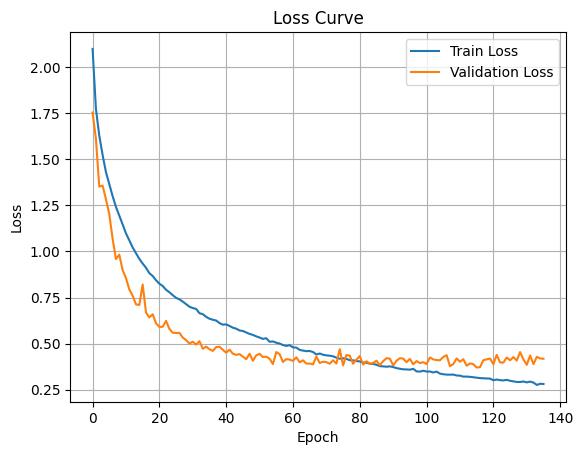

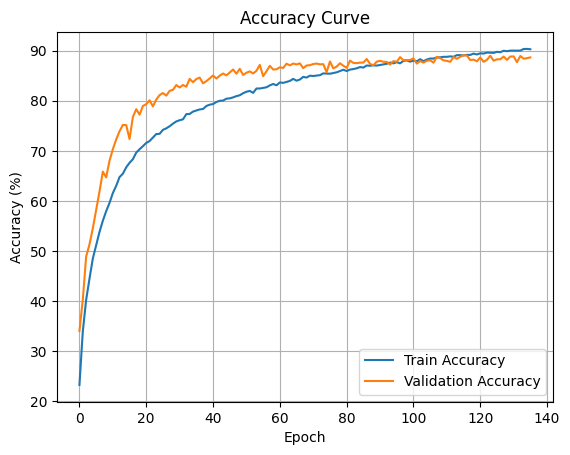

In [22]:
# Set up device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save model
model.to(device)

# Log training 
train_losses, val_losses = [], []
train_accuracies = []
val_accuracies = []

# Training and Validation Loops 
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss / len(loader), 100 * correct / total

# Main Loop 
patience = 20  # Number of epochs to wait for improvement
early_stop_counter = 0 # Counter for early stopping
epochs = 150
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)


    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        early_stop_counter=0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")
    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epochs.")

    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
print("\nTraining Complete")

# Print Final Averages 
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
avg_train_acc = sum(train_accuracies) / len(train_accuracies)
avg_val_acc = sum(val_accuracies) / len(val_accuracies)

print("\nFinal Averages Over All Epochs")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_acc:.2f}%")
print(f"Average Val   Loss: {avg_val_loss:.4f}")
print(f"Average Val   Accuracy: {avg_val_acc:.2f}%")


# Plot results

# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")

# Plot Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")

print("Plots saved: loss_curve.png and accuracy_curve.png")
